사전 학습된 ResNet 사용해보기

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [2]:
#GPU 사용장치 설정
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

ImageNet에 정의된 클래스 정보 가져오기

In [3]:
from urllib.request import urlretrieve
import json

#이미지넷에 정의된 1000개의 레이블 정보 가져오기
imagenet_json, _ = urlretrieve('http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
  imagenet_labels = json.load(f)

In [4]:
#index 18에 해당하는 것은 까치(magpie)
print(imagenet_labels[18])

magpie


이미지 처리 함수 정의 및 이미지 가져와 출력해보기
ResNet은 일반적으로 이미지에 대하여 Resize, CenterCrop, ToTensor()와 입력 데이터 정규화를 사용하는 모델이다.

In [12]:
preprocess = transforms.Compose([
                                 transforms.Resize(256),#이미지의 크기를 변경
                                 transforms.CenterCrop(224), #이미지의 중앙 부분을 잘라서 크기 조절
                                 transforms.ToTensor(), #torch.Tensor형식으로 변경
])


In [13]:
import matplotlib.pyplot as plt
import PIL

In [20]:
#특정한 경로에서 이미지를 가져와 torch.Tensor로 변환하는 함수
def image_loader(path):
  image = PIL.Image.open(path)
  #전처리 이후에 네트워크에 입력에 들어갈 이미지에 배치 목적의 차원 추가
  image = preprocess(image).unsqueeze(0)
  return image.to(device, torch.float) # GPU로 올리기


In [23]:
# 실제로 특정 URL에서 이미지를 불러오기 (얼룩 고양이)
url = "https://images.freeimages.com/images/large-previews/99d/calico-cat-1249550.jpg"
image_path, _ = urlretrieve(url)
image = image_loader(image_path)

In [24]:
#torch.Tensor 형태의 이미지를 화면에 출력하는 함수
def imshow(tensor):
  #matplotlib은 CPU 기반이므로 데이터를 옮겨야 한다.
  image = tensor.cpu().clone()
  #Tensor에서 사용되는 배치 목적의 차원 제거
  image = image.squeeze(0)
  #PIL 객체로 변경
  image = transforms.ToPILImage()(image)
  plt.imshow(image)


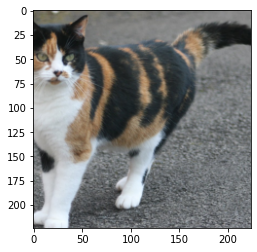

In [25]:
plt.figure()
imshow(image)

사전학습된 모델을 불러와 사용해보기

In [26]:
class Normalize(nn.Module):
  def __init__(self, mean, std):
    super(Normalize, self).__init__()
    self.register_buffer('mean', torch.Tensor(mean))
    self.register_buffer('std', torch.Tensor(std))
  def forward(self, input):
    mean = self.mean.reshape(1, 3, 1, 1)
    std = self.std.reshape(1, 3, 1, 1)
    return (input-mean)/std

In [27]:
#공격자가 가지고 있는 torch.Tensor 형식의 이미지 데이터는 입력 정규화를 거치기 전이므로, 정규화 이후에 모델에 넣도로
#설정
model = nn.Sequential(
    #기본적인 ResNet18과 동일한 동작을 위하여 정규화 레이어 추가
    Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained = True)
).to(device).eval() #모델을 GPU로 옮기고 평가 모드로 변경

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [29]:
outputs = model(image)

percentage = torch.nn.functional.softmax(outputs, dim = 1)[0]*100
print('<가장 높은 확률을 가지는 클래스들>')
for i in outputs[0].topk(5)[1]:
  print(f'index : {i.item()} / class name : {imagenet_labels[i]} / probability : {round(percentage[i].item(),4)}%')

<가장 높은 확률을 가지는 클래스들>
index : 281 / class name : tabby, tabby cat / probability : 22.8893%
index : 282 / class name : tiger cat / probability : 15.5918%
index : 248 / class name : Eskimo dog, husky / probability : 5.9043%
index : 285 / class name : Egyptian cat / probability : 5.4781%
index : 253 / class name : basenji / probability : 5.3058%
